In [11]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [3]:

ROOT = Path("..").resolve()

RAW_DIR = ROOT / "data" / "raw"
TRACKING_DIR = RAW_DIR / "tracking_data"
EVENT_DIR = RAW_DIR / "event_data"
METADATA_DIR = RAW_DIR / "metadata"
ROSTERS_DIR = RAW_DIR / "rosters"

print("ROOT:", ROOT)
print("TRACKING_DIR exists:", TRACKING_DIR.exists())
print("EVENT_DIR exists:", EVENT_DIR.exists())

ROOT: /Users/rafaellopez/Desktop/DS3/tactical-viewer-app
TRACKING_DIR exists: True
EVENT_DIR exists: True


In [ ]:
def load_tracking_sample(match_id: int, n_rows: int = 5000) -> pd.DataFrame:
    path = TRACKING_DIR / f"{match_id}.jsonl.bz2"
    if not path.exists():
        raise FileNotFoundError(f"Missing tracking file: {path}")

    df = pd.read_json(
        path,
        lines=True,
        compression="bz2",
        nrows=n_rows   
    )
    return df

tracking_3812 = load_tracking_sample(3812, n_rows=3000)
tracking_3812.head()

,version,gameRefId,generatedTime,smoothedTime,videoTimeMs,frameNum,period,periodElapsedTime,periodGameClockTime,homePlayers,homePlayersSmoothed,awayPlayers,awayPlayersSmoothed,balls,ballsSmoothed,game_event_id,possession_event_id,game_event,possession_event
0,4.1.0,3812.0,2024-08-22T21:38:04.474529Z,2024-08-28T07:13:57.330569Z,141007.674,4226,1,0.000000,0.000000,"[{'jerseyNum': '21', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '21', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '8', 'confidence': 'HIGH', 'vis...","[{'jerseyNum': '8', 'confidence': 'HIGH', 'vis...","[{'visibility': 'VISIBLE', 'x': -0.97, 'y': 0....","{'visibility': 'VISIBLE', 'x': 2.46, 'y': 1.58...",6497466.0,6373793.0,"{'game_id': 3812, 'game_event_type': 'FIRSTKIC...","{'game_id': 3812, 'game_event_id': 6497466, 'p..."
1,None,NaN,None,None,141041.041,4227,1,0.033041,0.033041,"[{'jerseyNum': '21', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '21', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '8', 'confidence': 'HIGH', 'vis...","[{'jerseyNum': '8', 'confidence': 'HIGH', 'vis...","[{'visibility': 'VISIBLE', 'x': -1.58, 'y': 0....","{'visibility': 'VISIBLE', 'x': 2.04, 'y': 1.62...",NaN,NaN,None,None
2,None,NaN,None,None,141074.408,4228,1,0.066408,0.066408,"[{'jerseyNum': '21', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '21', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '8', 'confidence': 'HIGH', 'vis...","[{'jerseyNum': '8', 'confidence': 'HIGH', 'vis...","[{'visibility': 'VISIBLE', 'x': -1.58, 'y': 0....","{'visibility': 'VISIBLE', 'x': 1.62, 'y': 1.67...",NaN,NaN,None,None
3,None,NaN,None,None,141107.774,4229,1,0.099774,0.099774,"[{'jerseyNum': '21', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '21', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '8', 'confidence': 'HIGH', 'vis...","[{'jerseyNum': '8', 'confidence': 'HIGH', 'vis...","[{'visibility': 'VISIBLE', 'x': -2.33, 'y': 0....","{'visibility': 'VISIBLE', 'x': 1.2, 'y': 1.71,...",NaN,NaN,None,None
4,None,NaN,None,None,141141.141,4230,1,0.133141,0.133141,"[{'jerseyNum': '21', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '21', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '8', 'confidence': 'HIGH', 'vis...","[{'jerseyNum': '8', 'confidence': 'HIGH', 'vis...","[{'visibility': 'VISIBLE', 'x': -2.33, 'y': 0....","{'visibility': 'VISIBLE', 'x': 0.78, 'y': 1.76...",NaN,NaN,None,None


In [6]:
# Pick one frame (first row for now)
frame = tracking_3812.iloc[0]

home = frame["homePlayersSmoothed"]
away = frame["awayPlayersSmoothed"]
ball = frame["ballsSmoothed"]

def players_to_df(players_list, team_label):
    rows = []
    for p in players_list:
        # Only keep players we can "see"
        if p.get("visibility") not in ["VISIBLE", "TRACKED", None]:
            continue

        rows.append({
            "team": team_label,
            "jerseyNum": p.get("jerseyNum"),
            "x": p.get("x"),
            "y": p.get("y"),
            "confidence": p.get("confidence")
        })
    return pd.DataFrame(rows)

players_df = pd.concat([
    players_to_df(home, "home"),
    players_to_df(away, "away")
], ignore_index=True)

ball_df = pd.DataFrame([{
    "x": ball.get("x"),
    "y": ball.get("y"),
    "visibility": ball.get("visibility")
}])

players_df, ball_df

(    team jerseyNum       x       y confidence
 0   home        21  14.357  18.306       HIGH
 1   home         4   7.543   4.958       HIGH
 2   home         6   9.501  -1.919       HIGH
 3   home        22  18.819 -21.928       HIGH
 4   home         5   7.011  -8.378       HIGH
 5   home        15   2.879  11.588       HIGH
 6   home        18   1.351 -22.141       HIGH
 7   home         8  18.662  -4.934       HIGH
 8   home         9  -0.771  -9.960       HIGH
 9   home         3  19.462   3.407       HIGH
 10  away         8   1.247 -11.488       HIGH
 11  away        21 -11.375   1.698       HIGH
 12  away         5 -21.746  14.948       HIGH
 13  away        18   2.461   1.580       HIGH
 14  away         4 -20.279   4.833       HIGH
 15  away        17  -7.984  25.201       HIGH
 16  away        11 -11.765  -4.032       HIGH
 17  away         3 -22.650 -16.070       HIGH
 18  away        22  -0.132 -33.214       HIGH
 19  away         7  -0.322   8.845       HIGH,
       x    

In [7]:
# Extract player coordinates from first ~100 frames
sample_frames = tracking_3812.iloc[:100]

all_x = []
all_y = []

for _, frame in sample_frames.iterrows():
    for side in ["homePlayersSmoothed", "awayPlayersSmoothed"]:
        players = frame[side]
        for p in players:
            if p.get("visibility") == "VISIBLE":
                all_x.append(p.get("x"))
                all_y.append(p.get("y"))

print("X range:", min(all_x), "to", max(all_x))
print("Y range:", min(all_y), "to", max(all_y))

X range: -22.65 to 19.462
Y range: -33.214 to 27.675


In [8]:
# Standard pitch dimensions (meters)
pitch_length = 105
pitch_width = 68

# Grid resolution (keep moderate for speed)
n_x_bins = 100
n_y_bins = 60

x_bins = np.linspace(-pitch_length/2, pitch_length/2, n_x_bins)
y_bins = np.linspace(-pitch_width/2, pitch_width/2, n_y_bins)

grid_x, grid_y = np.meshgrid(x_bins, y_bins)

print("Grid shape:", grid_x.shape)

Grid shape: (60, 100)


Everything looks good, players x y coordinates are high confidence meaning they are reliable. 
Sample coordinates are also within bounds and set up grid shape. Can move on to actual Vornoi stuff now


In [12]:
from scipy.spatial import KDTree

# 1) Pick one frame (same one you used before is fine)
frame = tracking_3812.iloc[0]

# 2) Build a (N_players, 2) array of player positions + matching labels
def get_positions_and_labels(frame):
    rows = []
    labels = []

    for team_col, team_label in [("homePlayersSmoothed", "home"), ("awayPlayersSmoothed", "away")]:
        for p in frame[team_col]:
            if p.get("visibility") != "VISIBLE":
                continue
            x, y = p.get("x"), p.get("y")
            j = p.get("jerseyNum")
            if x is None or y is None or j is None:
                continue
            rows.append([x, y])
            labels.append(f"{team_label}_{j}")  # e.g., "home_21"

    return np.array(rows, dtype=float), np.array(labels)

positions, labels = get_positions_and_labels(frame)

print("num players:", len(labels))
print("sample labels:", labels[:5])

# 3) Voronoi assignment via nearest neighbor
tree = KDTree(positions)

grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
_, nearest_idx = tree.query(grid_points)

assigned = labels[nearest_idx].reshape(grid_x.shape)  # same shape as grid

assigned[:3, :10]  # just to show it worked

num players: 20
sample labels: ['home_21' 'home_4' 'home_6' 'home_22' 'home_5']


array([['away_3', 'away_3', 'away_3', 'away_3', 'away_3', 'away_3',
        'away_3', 'away_3', 'away_3', 'away_3'],
       ['away_3', 'away_3', 'away_3', 'away_3', 'away_3', 'away_3',
        'away_3', 'away_3', 'away_3', 'away_3'],
       ['away_3', 'away_3', 'away_3', 'away_3', 'away_3', 'away_3',
        'away_3', 'away_3', 'away_3', 'away_3']], dtype='<U7')

In [13]:
# area per grid cell (m^2)
cell_area = (pitch_length / (n_x_bins - 1)) * (pitch_width / (n_y_bins - 1))

unique, counts = np.unique(assigned, return_counts=True)
area_by_player = pd.DataFrame({
    "player": unique,
    "cells": counts,
    "area_m2": counts * cell_area
}).sort_values("area_m2", ascending=False)

area_by_player.head(10)

,player,cells,area_m2
5,away_3,963,1177.164869
7,away_5,785,959.578839
13,home_22,727,888.680021
12,home_21,720,880.123267
14,home_3,597,729.768875
18,home_8,360,440.061633
6,away_4,357,436.394453
1,away_17,334,408.279404
11,home_18,182,222.475603
4,away_22,160,195.582948


In [14]:
cell_area = (pitch_length / n_x_bins) * (pitch_width / n_y_bins)

unique, counts = np.unique(assigned, return_counts=True)
area_by_player = pd.DataFrame({
    "player": unique,
    "cells": counts,
    "area_m2": counts * cell_area
}).sort_values("area_m2", ascending=False)

area_by_player.head(10), area_by_player["area_m2"].sum()

(     player  cells  area_m2
 5    away_3    963  1145.97
 7    away_5    785   934.15
 13  home_22    727   865.13
 12  home_21    720   856.80
 14   home_3    597   710.43
 18   home_8    360   428.40
 6    away_4    357   424.83
 1   away_17    334   397.46
 11  home_18    182   216.58
 4   away_22    160   190.40,
 np.float64(7139.999999999999))

In [15]:
home_area = area_by_player[area_by_player["player"].str.startswith("home_")]["area_m2"].sum()
away_area = area_by_player[area_by_player["player"].str.startswith("away_")]["area_m2"].sum()

home_area, away_area, home_area + away_area

(np.float64(3542.63), np.float64(3597.37), np.float64(7140.0))

In [ ]:
def voronoi_team_area(frame):
    positions, labels = get_positions_and_labels(frame)
    tree = KDTree(positions)

    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    _, nearest_idx = tree.query(grid_points)
    assigned = labels[nearest_idx].reshape(grid_x.shape)

    unique, counts = np.unique(assigned, return_counts=True)
    area_by_player = pd.DataFrame({"player": unique, "cells": counts})
    area_by_player["area_m2"] = area_by_player["cells"] * cell_area

    home_area = area_by_player[area_by_player["player"].str.startswith("home_")]["area_m2"].sum()
    away_area = area_by_player[area_by_player["player"].str.startswith("away_")]["area_m2"].sum()
    return home_area, away_area

# compute for first 100 frames
frames = tracking_3812.iloc[:100]

home_series = []
away_series = []
times = frames["videoTimeMs"].values

for _, f in frames.iterrows():
    h, a = voronoi_team_area(f)
    home_series.append(h)
    away_series.append(a)

plt.figure()
plt.plot(times, home_series, label="home")
plt.plot(times, away_series, label="away")
plt.xlabel("videoTimeMs")
plt.ylabel("Voronoi area (m²)")
plt.legend()
plt.show()

Goal

Compute spatial control using a Voronoi approach on tracking data.

Method
	•	Use smoothed player positions (homePlayersSmoothed, awayPlayersSmoothed)
	•	Build a pitch grid (105m x 68m)
	•	Assign each grid cell to the nearest player using KDTree
	•	Count cells → convert to area (m²)

What We Verified
	•	Coordinates are centered at (0,0)
	•	Total Voronoi area ≈ 7140 m² (correct pitch area)
	•	Team areas change over time as players move

Outputs
	•	Player-level space (m²)
	•	Team-level space (home vs away)
	•	Time series of spatial dominance


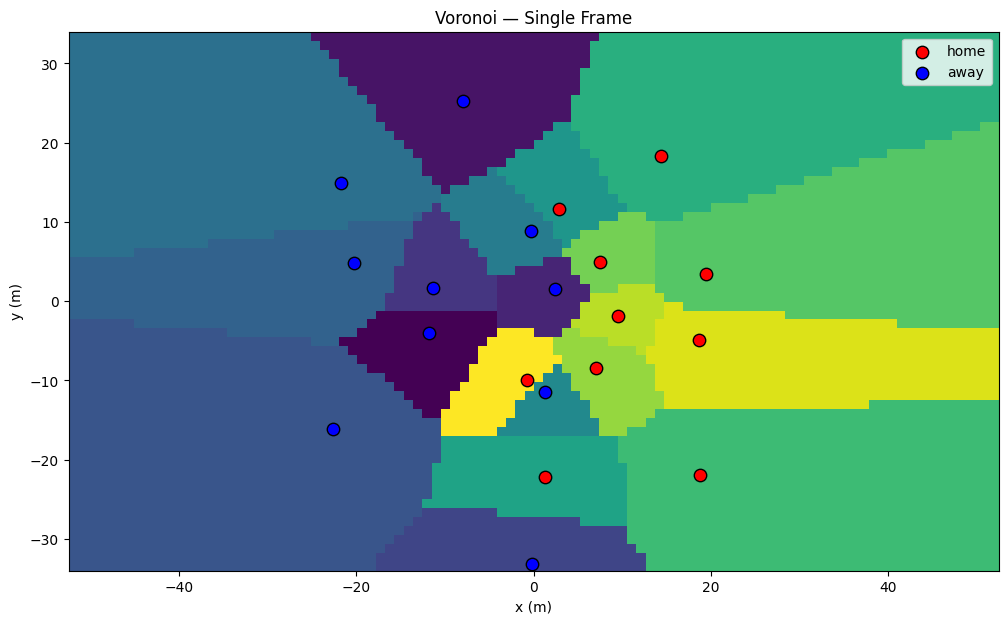

In [18]:
plt.figure(figsize=(12, 7))

plt.imshow(
    assigned_int,
    origin="lower",
    extent=[-pitch_length/2, pitch_length/2, -pitch_width/2, pitch_width/2],
    aspect="auto"
)

# Separate home and away for clarity
home_mask = [lab.startswith("home_") for lab in labels]
away_mask = [lab.startswith("away_") for lab in labels]

plt.scatter(
    positions[home_mask, 0],
    positions[home_mask, 1],
    c="red",
    s=80,
    edgecolor="black",
    label="home"
)

plt.scatter(
    positions[away_mask, 0],
    positions[away_mask, 1],
    c="blue",
    s=80,
    edgecolor="black",
    label="away"
)

plt.legend()
plt.title("Voronoi — Single Frame")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

Now:

	•	🔴 Home players = red

	•	🔵 Away players = blue

	•	Bigger dots
	
	•	Black edge so they pop

In [19]:
print("Home players kept:", sum(home_mask))
print("Away players kept:", sum(away_mask))

home_nums = sorted([int(l.split("_")[1]) for l in labels if l.startswith("home_")])
away_nums = sorted([int(l.split("_")[1]) for l in labels if l.startswith("away_")])

print("Home jersey nums:", home_nums)
print("Away jersey nums:", away_nums)

Home players kept: 10
Away players kept: 10
Home jersey nums: [3, 4, 5, 6, 8, 9, 15, 18, 21, 22]
Away jersey nums: [3, 4, 5, 7, 8, 11, 17, 18, 21, 22]
